In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import ttest_ind, mannwhitneyu

In [55]:
df = pd.read_csv('submission.csv', encoding='ISO-8859-1')

## is_converted 칼럼 정리

In [56]:
#1. is_converted가 NA인 데이터 drop
original_rows = len(df)
df = df.dropna(subset=['is_converted'])
erased_rows = original_rows - len(df)
print('지워진 행: '+str(erased_rows))

지워진 행: 0


In [57]:
print('is_converted unique values:')
df.is_converted.unique()

is_converted unique values:


array([ True, False])

In [58]:
# is_converted 의 값들 정리
# 모두 TRUE or FALSE로 통일, 이외값을 가진 행은 제거
df['is_converted'] = df['is_converted'].astype(str).str.upper()
df = df[df['is_converted'].isin(['TRUE', 'FALSE'])]
print('지워진 행: '+ str(original_rows-erased_rows-len(df)))

지워진 행: 0


## 중복 행 처리

In [59]:
df.drop_duplicates(keep='first', inplace=True)
len(df)

5271

## NA율 50% 이상 90% 이하 칼럼들 처리

In [60]:
#칼럼별 NA율이 90% 이상인 칼럼 제외
# drop columns with more than 90% missing values
# dropped_columns = []
# for col in df.columns:
#     if df[col].isnull().sum()/len(df)*100 > 90:
#         df.drop(col, axis=1, inplace=True)
        
# print('number of columns left: '+str(len(df.columns)))

# 칼럼은 train에서 지우면 test에서도 지워야 하므로, 둘 다 지우지 않음

In [61]:
dropped_columns = []
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 90:
        print(col)

it_strategic_ver


In [62]:
df.id_strategic_ver.fillna(0, inplace=True)
df.it_strategic_ver.fillna(0, inplace=True)
df.idit_strategic_ver.fillna(0, inplace=True)

print(df.id_strategic_ver.unique())
print(df.it_strategic_ver.unique())
print(df.idit_strategic_ver.unique())


[0. 1.]
[0. 1.]
[0. 1.]


In [63]:
df.business_subarea.fillna('NA', inplace=True)
print(df.business_subarea.unique())

['Electronics & Telco' 'Others' 'General Hospital' 'NA' 'Engineering'
 'Banking' 'Hospital' 'K12 Kindergarten & Schools' 'Construction'
 'Advertising' 'Higher Education (College & University)'
 'Manufacturing Factory / Plant' 'Other Stores' 'Fashion'
 'Telecommunication' 'Mixed-use (Multi Complex)' 'Institute & Academy'
 'Fitness' 'IT/Software' 'Restaurant' 'Cosmetics' 'Healthcare' 'Hotel'
 'Military' 'Clinic' 'Manufacturing' 'Apartment' 'Townhouse' 'Resort'
 'Finance' 'Religious Facility' 'Broadcasting & Media' 'Holdings'
 'Villa / Single-Family Home' 'Power Plant' 'Developer/Property'
 'Renewable Energy' 'Entertainment' 'Sports Entertainment'
 'Telecom Base Station / Data, Call' 'Hyper Market & Grocery'
 'Bus Terminal' 'Luxury(Watch/Jewelry Shop)' 'Logistics' 'Gas Station'
 'Energy' 'General Government Office' 'Outdoor Advertisement' 'Investment'
 'Shopping Mall' 'Energy Storage & Saving' 'F&B(Food and Beverage)'
 'Exhibition / Convention Center' 'Consulting' 'Insurance'
 'QSR(Quick 

In [64]:
#칼럼별 NA율이 50% 이상인 칼럼 나열
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 50:
        print(col, df[col].isnull().sum()/len(df)*100)
        #df.drop(col, axis=1, inplace=True)

com_reg_ver_win_rate 66.07854297097326
historical_existing_cnt 75.81104154809334
product_subcategory 84.95541642952001
product_modelname 89.33788654904193
ver_win_rate_x 54.980079681274894
ver_win_ratio_per_bu 63.83987858091443
business_area 54.980079681274894


### com_reg_ver_win_rate

In [65]:
# Replace NA values in 'com_reg_ver_win_rate' with 0.15
# df['com_reg_ver_win_rate'] = df['com_reg_ver_win_rate'].fillna(0.15)

Odds Ratio for NA values in 'com_reg_ver_win_rate': 0.22210526315789472


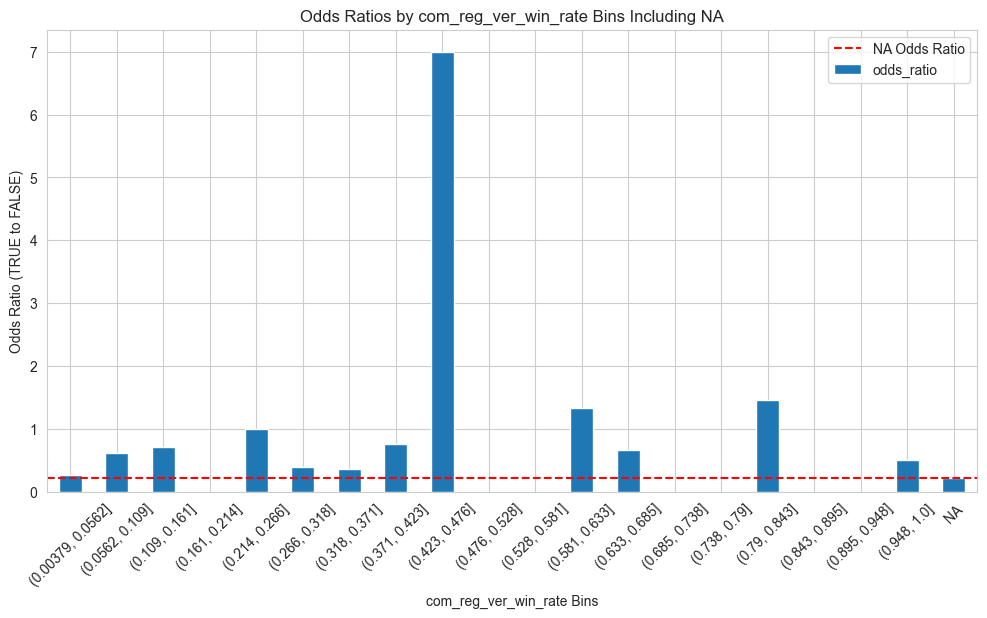

In [66]:
# impute하기전

# Separate groups
na_group = df[df['com_reg_ver_win_rate'].isna()]
non_na_group = df[~df['com_reg_ver_win_rate'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'com_reg_ver_win_rate': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['com_reg_ver_win_rate'].min(), non_na_group['com_reg_ver_win_rate'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['com_reg_ver_win_rate'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('com_reg_ver_win_rate Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by com_reg_ver_win_rate Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [67]:
from sklearn.impute import KNNImputer

# Initialize the KNN Imputer with default parameters (you can choose to modify these)
imputer = KNNImputer(n_neighbors=5)

# It's important to note that KNNImputer works with numerical data, so we need to ensure that 'ver_win_rate_x' is of a numerical type
# Let's first ensure the column is of a numerical type, converting it if necessary
df['com_reg_ver_win_rate'] = pd.to_numeric(df['com_reg_ver_win_rate'], errors='coerce')

# Apply the imputer to the DataFrame
# df_imputed = df.copy()
# df_imputed['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
df['com_reg_ver_win_rate'] = imputer.fit_transform(df[['com_reg_ver_win_rate']])
# Check the first few entries of the column to verify imputation
# df_imputed['ver_win_rate_x'].head()
df['com_reg_ver_win_rate'].head()

0    0.073248
1    0.102336
2    0.102336
3    0.118644
4    0.074949
Name: com_reg_ver_win_rate, dtype: float64

Odds Ratio for NA values in 'com_reg_ver_win_rate': 0.0


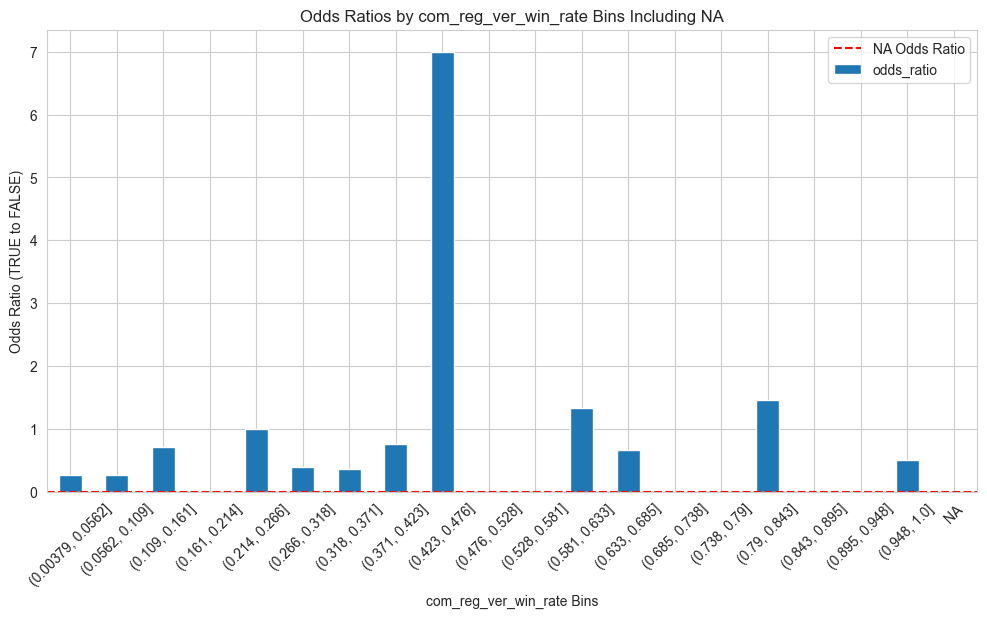

In [68]:
#impute한 후

# Separate groups
na_group = df[df['com_reg_ver_win_rate'].isna()]
non_na_group = df[~df['com_reg_ver_win_rate'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'com_reg_ver_win_rate': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['com_reg_ver_win_rate'].min(), non_na_group['com_reg_ver_win_rate'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['com_reg_ver_win_rate'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('com_reg_ver_win_rate Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by com_reg_ver_win_rate Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### customer_type

In [69]:
df['customer_type'] = df['customer_type'].fillna('Unknown')

Odds Ratio for NA values in 'customer_type': 0.0


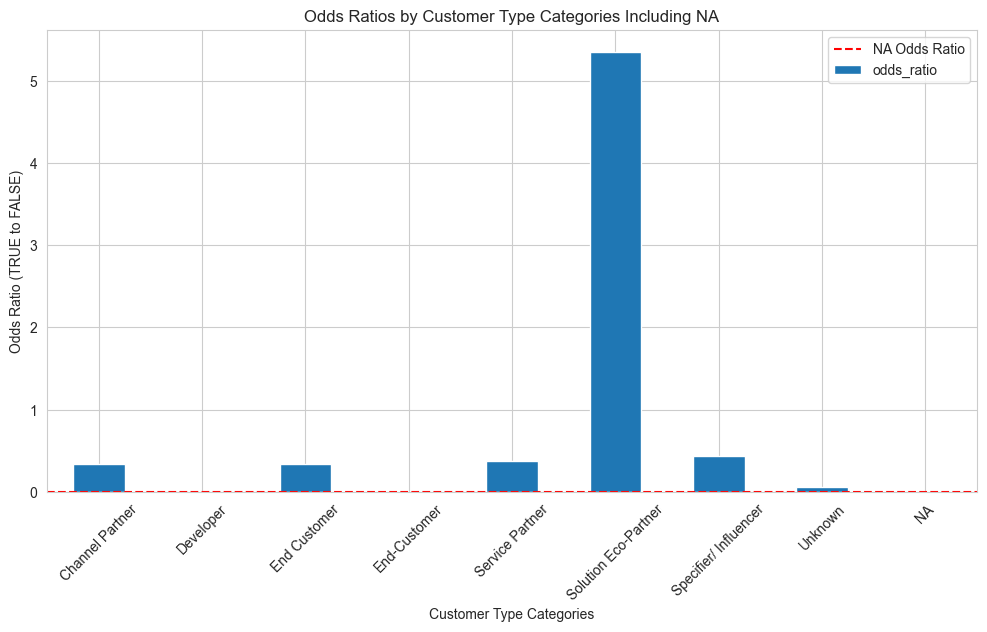

In [70]:
# Separate groups
na_group = df[df['customer_type'].isna()]
non_na_group = df[~df['customer_type'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'customer_type': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('customer_type')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('Customer Type Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by Customer Type Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### historical_existing_cnt

In [71]:
#도메인 지식으로는, 이 데이터가 회사에서 온것이므로, 회사가 단 한번이라도 고객을 상대했더라면 그 기록이 남았을것이다. 
# 따라서 이 칼럼의 NA는 전적이 없다, 즉 0으로 채울 수 있다. Domain Knowledge에 의한 imputation

# df = df.drop(columns=['historical_existing_cnt'])

df.historical_existing_cnt.fillna(0, inplace=True)
df.historical_existing_cnt.unique()

array([5.300e+01, 0.000e+00, 2.000e+00, 3.200e+01, 1.100e+01, 1.000e+00,
       1.900e+01, 1.300e+01, 5.100e+01, 3.000e+00, 4.000e+00, 1.000e+01,
       1.600e+01, 2.900e+01, 4.800e+01, 2.200e+01, 6.000e+00, 1.380e+02,
       2.600e+01, 1.800e+01, 1.050e+02, 6.200e+01, 8.000e+00, 1.400e+01,
       6.100e+01, 1.220e+02, 9.800e+01, 5.000e+00, 1.720e+02, 1.700e+01,
       9.500e+01, 1.790e+02, 1.430e+02, 2.040e+02, 4.200e+01, 5.500e+01,
       3.300e+01, 3.000e+01, 5.700e+01, 1.290e+02, 4.000e+01, 1.150e+02,
       2.219e+03, 6.500e+01, 9.000e+00, 2.700e+01, 7.000e+00, 2.400e+01,
       3.900e+02, 1.200e+01, 3.400e+01, 3.500e+01, 2.100e+01, 3.900e+01,
       1.500e+01, 8.700e+01, 2.230e+02, 2.000e+01, 7.400e+01, 2.500e+01,
       4.500e+01, 3.100e+01, 2.440e+02, 2.800e+01, 1.230e+02, 1.390e+02,
       6.000e+01, 1.480e+02, 4.100e+01, 2.710e+02, 2.430e+02, 4.900e+01,
       1.550e+02, 2.300e+01])

Odds Ratio for NA values in 'historical_existing_cnt': 0.0


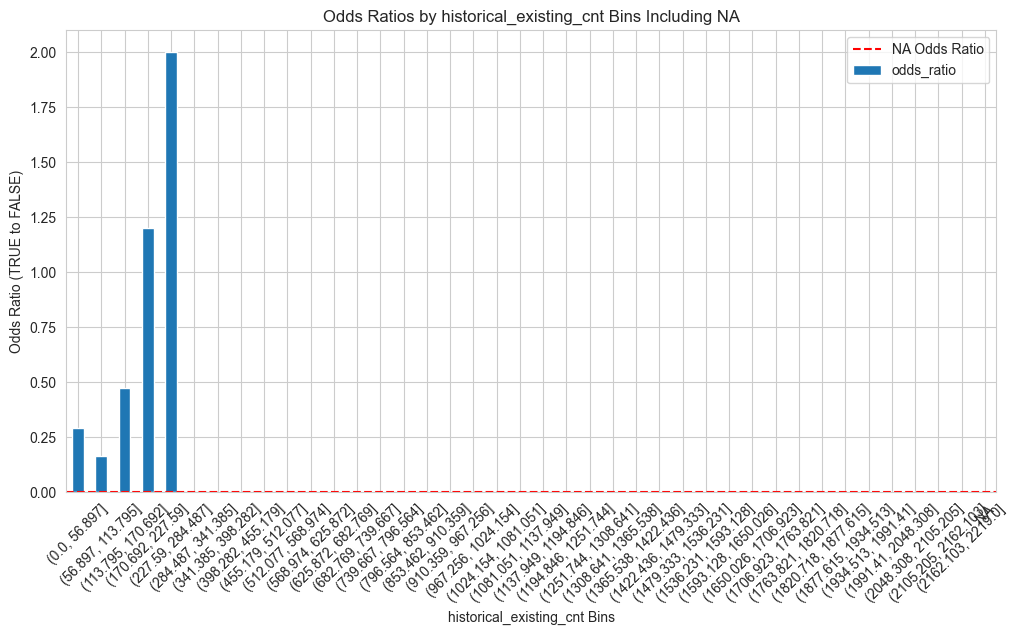

In [72]:
# Separate groups
na_group = df[df['historical_existing_cnt'].isna()]
non_na_group = df[~df['historical_existing_cnt'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'historical_existing_cnt': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['historical_existing_cnt'].min(), non_na_group['historical_existing_cnt'].max(), 40)
non_na_group['binned'] = pd.cut(non_na_group['historical_existing_cnt'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('historical_existing_cnt Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by historical_existing_cnt Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [73]:
len(df.columns)
df.columns

Index(['id', 'bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area',
       'business_subarea', 'lead_owner', 'is_converted'],
      dtype='object')

## product subcategory

In [74]:
df['product_subcategory'] = df['product_subcategory'].fillna('NA')

Odds Ratio for NA values in 'product_subcategory': 0.0


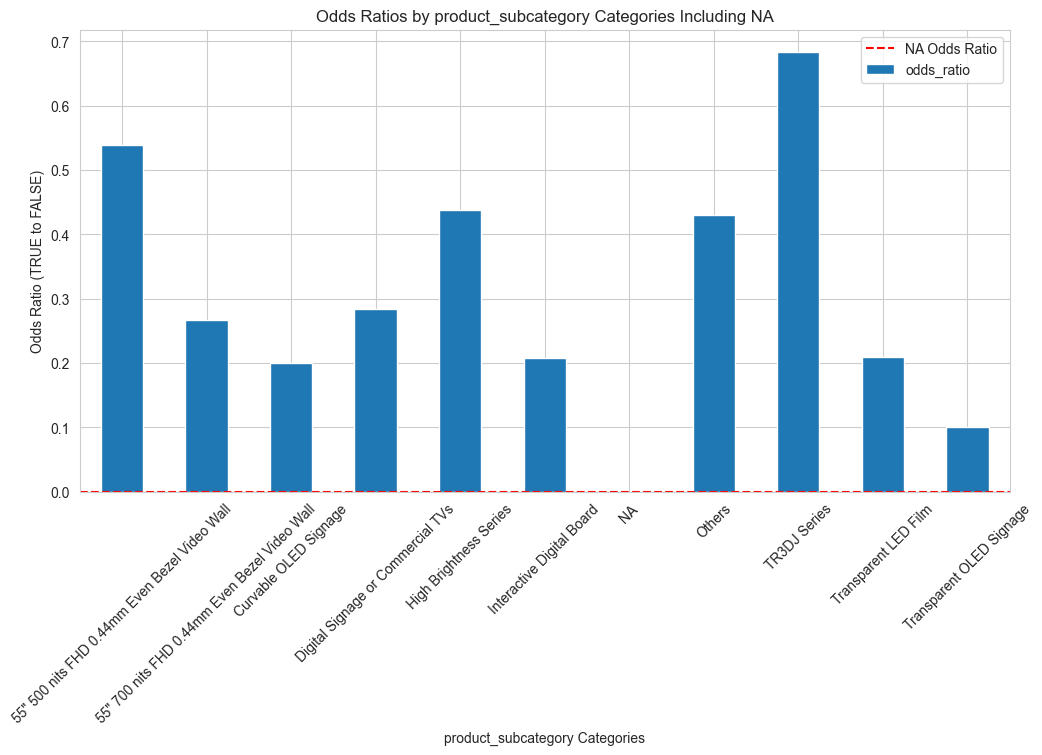

In [75]:
# 최고 10개만 거르는 코드
top_10_subcategories = df['product_subcategory'].value_counts().nlargest(10).index
df['product_subcategory'] = df['product_subcategory'].apply(lambda x: x if x in top_10_subcategories else 'Others')

# Separate groups
na_group = df[df['product_subcategory'].isna()]
non_na_group = df[~df['product_subcategory'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'product_subcategory': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('product_subcategory')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('product_subcategory Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by product_subcategory Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## product_modelname

In [76]:
df['product_modelname'] = df['product_modelname'].fillna('NA')

Odds Ratio for NA values in 'product_modelname': 0.0


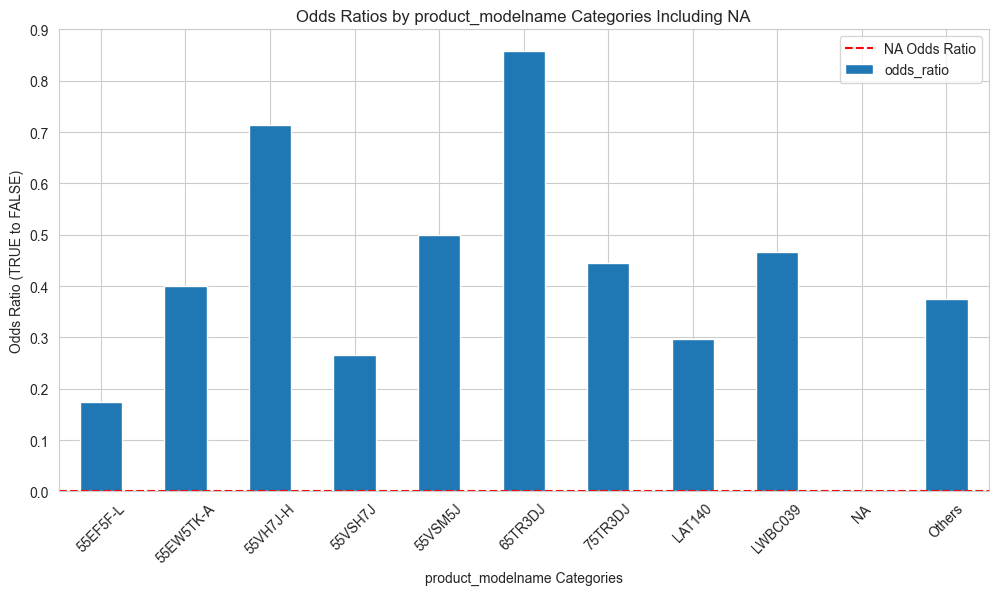

In [77]:
# 최고 10개만 거르는 코드
top_10_subcategories = df['product_modelname'].value_counts().nlargest(10).index
df['product_modelname'] = df['product_modelname'].apply(lambda x: x if x in top_10_subcategories else 'Others')

# Separate groups
na_group = df[df['product_modelname'].isna()]
non_na_group = df[~df['product_modelname'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'product_modelname': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('product_modelname')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('product_modelname Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by product_modelname Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## expected_timeline

In [78]:
# Replace the specified 'expected_timeline' values
df['expected_timeline'] = df['expected_timeline'].replace({
    'less_than_3_months': 'less than 3 months',  # merge into 'less than 3 months'
    'being followed up': 'being followed up.',  # merge into 'being followed up.'
    'less than 6 months': '3 months ~ 6 months',  # merge into '3 months ~ 6 months'
    '3_months_~_6_months' : '3 months ~ 6 months'
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['expected_timeline'].value_counts()
print(updated_counts)

expected_timeline
less than 3 months     1734
3 months ~ 6 months     426
more than a year        272
9 months ~ 1 year       264
6 months ~ 9 months     167
Name: count, dtype: int64


In [79]:
top_expected_timelines = df['expected_timeline'].value_counts().nlargest(6).index

# Replace all other 'expected_timeline' values with 'Others'
df['expected_timeline'] = df['expected_timeline'].apply(lambda x: x if x in top_expected_timelines else 'Others')

In [80]:
df['expected_timeline'] = df['expected_timeline'].fillna('etc')

Odds Ratio for NA values in 'expected_timeline': 0.0


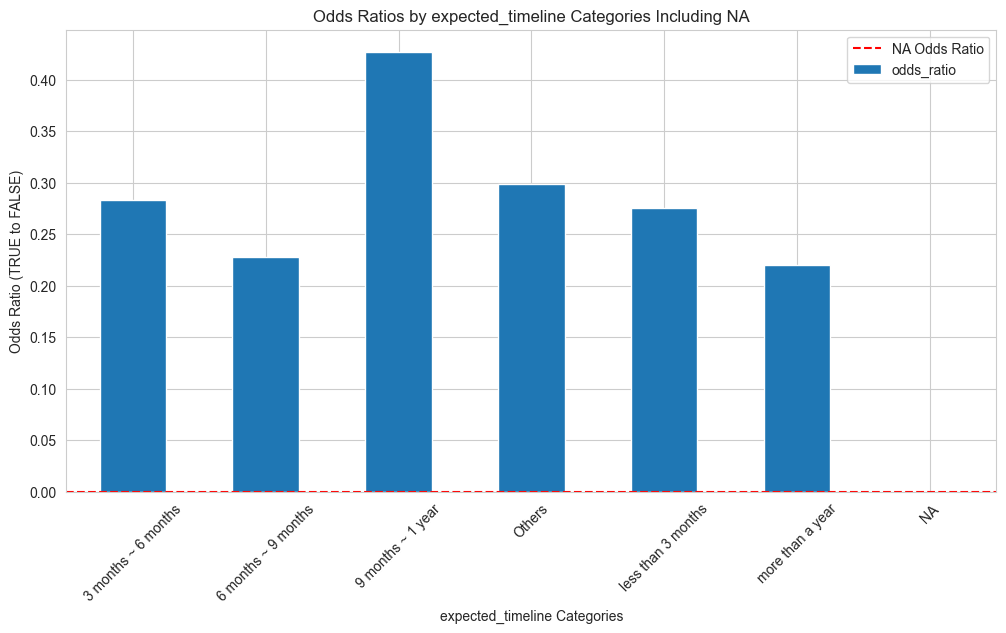

In [81]:
# Separate groups
na_group = df[df['expected_timeline'].isna()]
non_na_group = df[~df['expected_timeline'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'expected_timeline': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('expected_timeline')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('expected_timeline Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by expected_timeline Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## ver_win_rate_x

In [82]:
# 여기는 좀 고민이됨.
# df['ver_win_rate_x'] = df['ver_win_rate_x'].fillna()

Odds Ratio for NA values in 'ver_win_rate_x': 0.14908802537668517


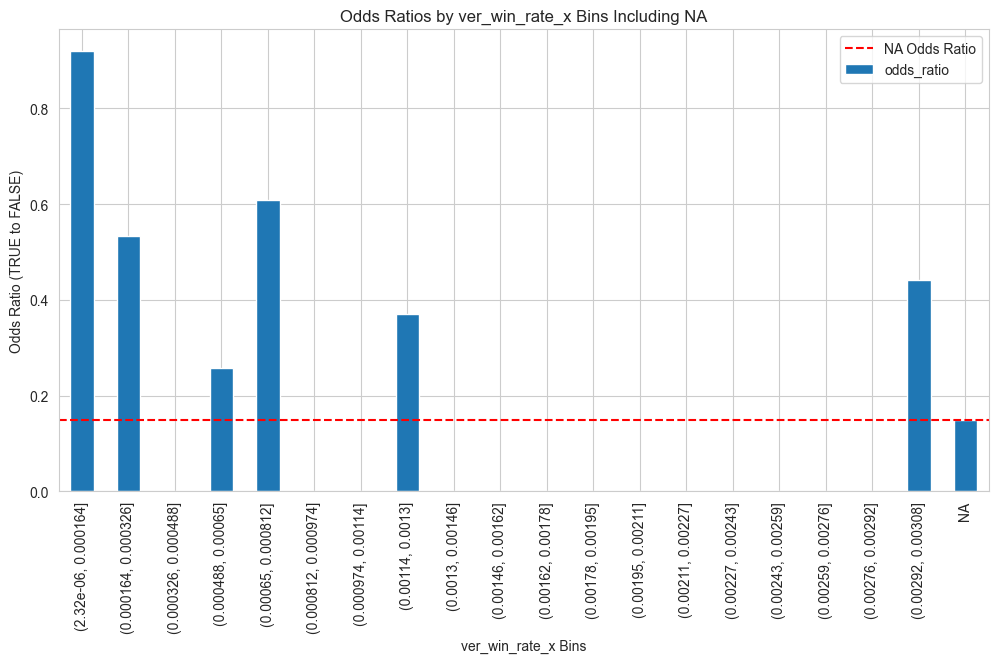

In [83]:
# Separate groups
na_group = df[df['ver_win_rate_x'].isna()]
non_na_group = df[~df['ver_win_rate_x'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'ver_win_rate_x': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['ver_win_rate_x'].min(), non_na_group['ver_win_rate_x'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['ver_win_rate_x'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_rate_x Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_rate_x Bins Including NA')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [84]:
from sklearn.impute import KNNImputer

# Initialize the KNN Imputer with default parameters (you can choose to modify these)
imputer = KNNImputer(n_neighbors=5)

# It's important to note that KNNImputer works with numerical data, so we need to ensure that 'ver_win_rate_x' is of a numerical type
# Let's first ensure the column is of a numerical type, converting it if necessary
df['ver_win_rate_x'] = pd.to_numeric(df['ver_win_rate_x'], errors='coerce')

# Apply the imputer to the DataFrame
# df_imputed = df.copy()
# df_imputed['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
df['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
# Check the first few entries of the column to verify imputation
# df_imputed['ver_win_rate_x'].head()
df['ver_win_rate_x'].head()

0    0.001183
1    0.000013
2    0.000060
3    0.001183
4    0.003079
Name: ver_win_rate_x, dtype: float64

Odds Ratio for NA values in 'ver_win_rate_x': 0.0


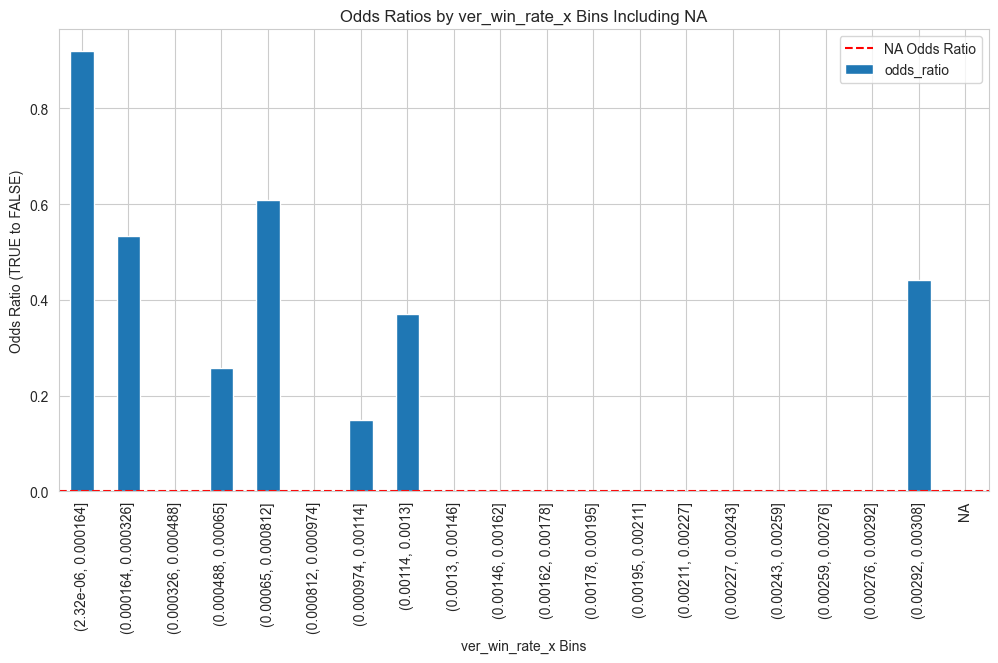

In [85]:
# Separate groups
na_group = df[df['ver_win_rate_x'].isna()]
non_na_group = df[~df['ver_win_rate_x'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'ver_win_rate_x': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['ver_win_rate_x'].min(), non_na_group['ver_win_rate_x'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['ver_win_rate_x'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_rate_x Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_rate_x Bins Including NA')
plt.legend()
plt.xticks(rotation=90)
plt.show()

## ver_win_ratio_per_bu

Odds Ratio for NA values in 'ver_win_ratio_per_bu': 0.2267590229675538


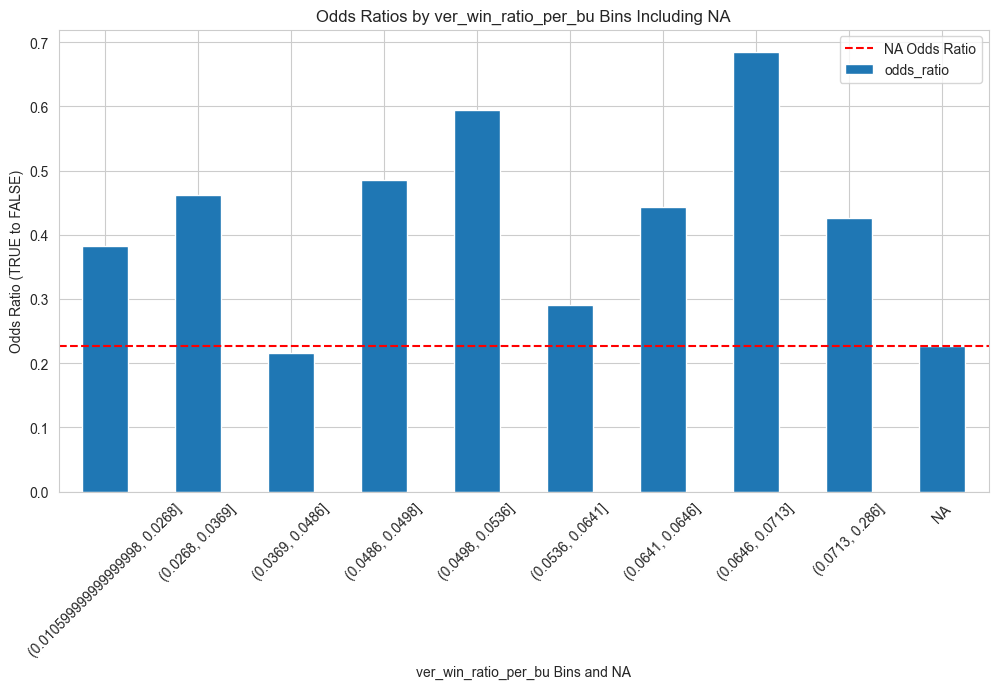

In [86]:
# Calculate odds ratio for NA group in 'ver_win_ratio_per_bu'
na_group_ver_bu = df[df['ver_win_ratio_per_bu'].isna()]
odds_ratio_na_ver_bu = na_group_ver_bu['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group_ver_bu['is_converted'].value_counts(normalize=True).get('FALSE', 1)

print(f"Odds Ratio for NA values in 'ver_win_ratio_per_bu': {odds_ratio_na_ver_bu}")

# Working with the non-NA subset for 'ver_win_ratio_per_bu'
non_na_group_ver_bu = df.dropna(subset=['ver_win_ratio_per_bu'])

# Bin 'ver_win_ratio_per_bu' into quantiles for fair distribution
non_na_group_ver_bu['ver_win_ratio_per_bu_binned'] = pd.qcut(non_na_group_ver_bu['ver_win_ratio_per_bu'], q=10, duplicates='drop')

# Calculate odds ratio for each bin
binned_odds_ratios_ver_bu = non_na_group_ver_bu.groupby('ver_win_ratio_per_bu_binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios_ver_bu['odds_ratio'] = binned_odds_ratios_ver_bu['TRUE'] / binned_odds_ratios_ver_bu['FALSE']

# Find bin with odds ratio closest to that of NA values
closest_bin_ver_bu = binned_odds_ratios_ver_bu.iloc[(binned_odds_ratios_ver_bu['odds_ratio'] - odds_ratio_na_ver_bu).abs().argsort()[:1]]

# Visualization
plt.figure(figsize=(12, 6))

# Convert index to string for consistent handling and visualization
binned_odds_ratios_ver_bu.index = binned_odds_ratios_ver_bu.index.astype(str)

# Now adding 'NA' as a string should not cause sorting issues
binned_odds_ratios_ver_bu.loc['NA', 'odds_ratio'] = odds_ratio_na_ver_bu

# Sort index alphabetically, which now includes 'NA' as a comparable string type
binned_odds_ratios_ver_bu = binned_odds_ratios_ver_bu.sort_index()

binned_odds_ratios_ver_bu['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na_ver_bu, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_ratio_per_bu Bins and NA')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_ratio_per_bu Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [87]:
# df['ver_win_ratio_per_bu'] = df['ver_win_ratio_per_bu'].fillna(0.0645)

from sklearn.impute import KNNImputer

# Initialize the KNN Imputer with default parameters (you can choose to modify these)
imputer = KNNImputer(n_neighbors=5)

# It's important to note that KNNImputer works with numerical data, so we need to ensure that 'ver_win_rate_x' is of a numerical type
# Let's first ensure the column is of a numerical type, converting it if necessary
df['ver_win_ratio_per_bu'] = pd.to_numeric(df['ver_win_ratio_per_bu'], errors='coerce')

# Apply the imputer to the DataFrame
# df_imputed = df.copy()
# df_imputed['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
df['ver_win_ratio_per_bu'] = imputer.fit_transform(df[['ver_win_ratio_per_bu']])
# Check the first few entries of the column to verify imputation
# df_imputed['ver_win_rate_x'].head()
df['ver_win_ratio_per_bu'].head()

0    0.049840
1    0.058388
2    0.131148
3    0.049840
4    0.064566
Name: ver_win_ratio_per_bu, dtype: float64

Odds Ratio for NA values in 'ver_win_ratio_per_bu': 0.0


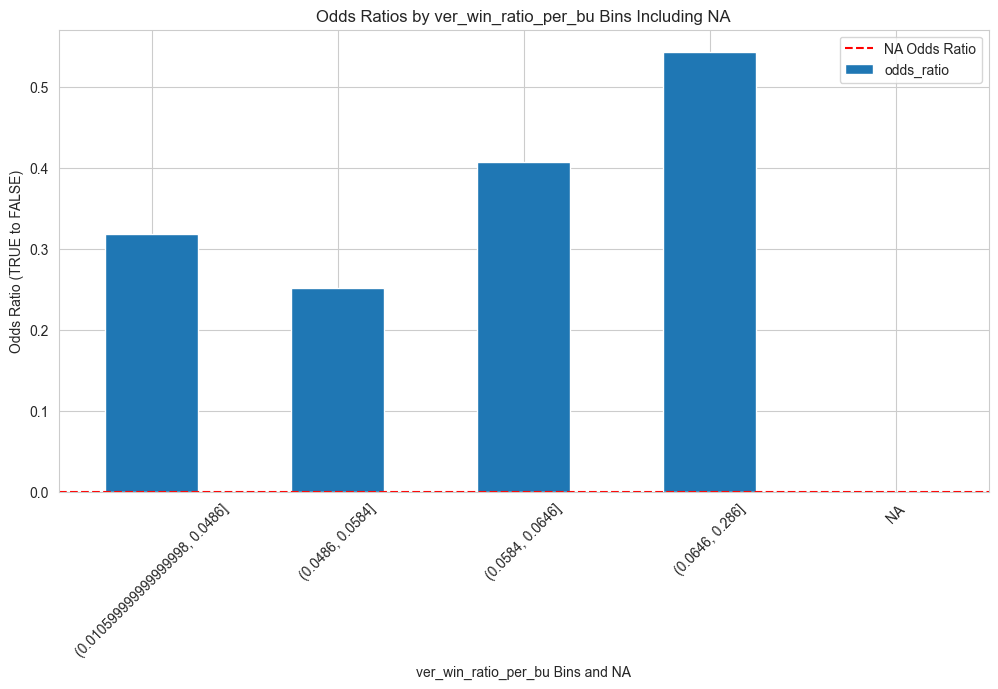

In [88]:
# Calculate odds ratio for NA group in 'ver_win_ratio_per_bu'
na_group_ver_bu = df[df['ver_win_ratio_per_bu'].isna()]
odds_ratio_na_ver_bu = na_group_ver_bu['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group_ver_bu['is_converted'].value_counts(normalize=True).get('FALSE', 1)

print(f"Odds Ratio for NA values in 'ver_win_ratio_per_bu': {odds_ratio_na_ver_bu}")

# Working with the non-NA subset for 'ver_win_ratio_per_bu'
non_na_group_ver_bu = df.dropna(subset=['ver_win_ratio_per_bu'])

# Bin 'ver_win_ratio_per_bu' into quantiles for fair distribution
non_na_group_ver_bu['ver_win_ratio_per_bu_binned'] = pd.qcut(non_na_group_ver_bu['ver_win_ratio_per_bu'], q=10, duplicates='drop')

# Calculate odds ratio for each bin
binned_odds_ratios_ver_bu = non_na_group_ver_bu.groupby('ver_win_ratio_per_bu_binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios_ver_bu['odds_ratio'] = binned_odds_ratios_ver_bu['TRUE'] / binned_odds_ratios_ver_bu['FALSE']

# Find bin with odds ratio closest to that of NA values
closest_bin_ver_bu = binned_odds_ratios_ver_bu.iloc[(binned_odds_ratios_ver_bu['odds_ratio'] - odds_ratio_na_ver_bu).abs().argsort()[:1]]

# Visualization
plt.figure(figsize=(12, 6))

# Convert index to string for consistent handling and visualization
binned_odds_ratios_ver_bu.index = binned_odds_ratios_ver_bu.index.astype(str)

# Now adding 'NA' as a string should not cause sorting issues
binned_odds_ratios_ver_bu.loc['NA', 'odds_ratio'] = odds_ratio_na_ver_bu

# Sort index alphabetically, which now includes 'NA' as a comparable string type
binned_odds_ratios_ver_bu = binned_odds_ratios_ver_bu.sort_index()

binned_odds_ratios_ver_bu['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na_ver_bu, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_ratio_per_bu Bins and NA')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_ratio_per_bu Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## business_area

In [89]:
df['business_area'] = df['business_area'].fillna('NA')

Odds Ratio for NA values in 'business_area': 0.0


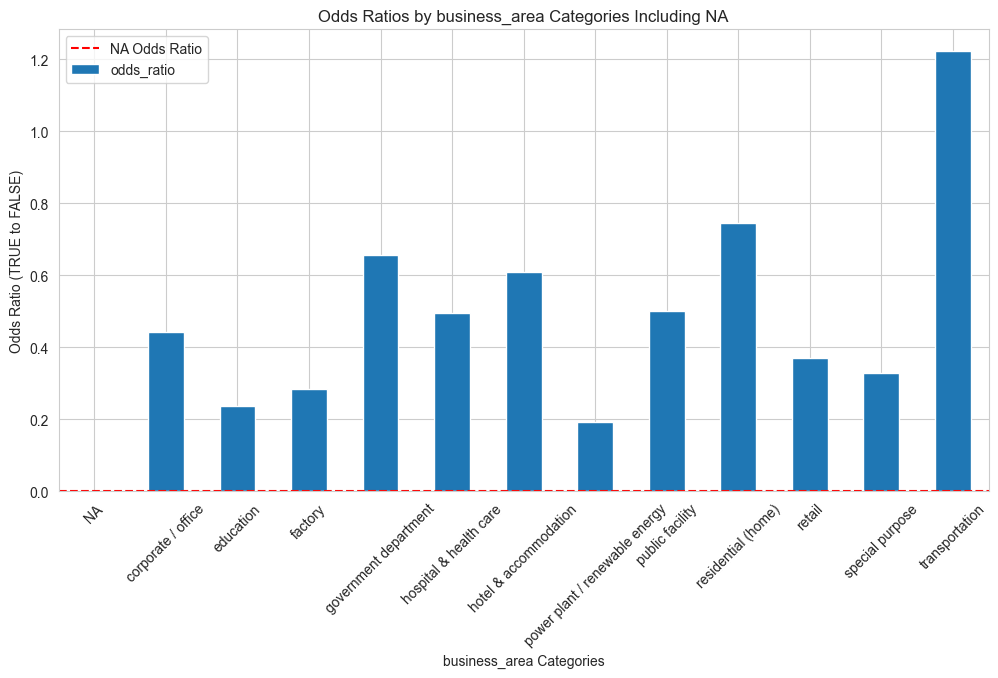

In [90]:
# Separate groups
na_group = df[df['business_area'].isna()]
non_na_group = df[~df['business_area'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'business_area': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('business_area')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('business_area Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by business_area Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# NA율 50% 이하

## customer_job

In [91]:
df['customer_job'] = df['customer_job'].fillna('NA')

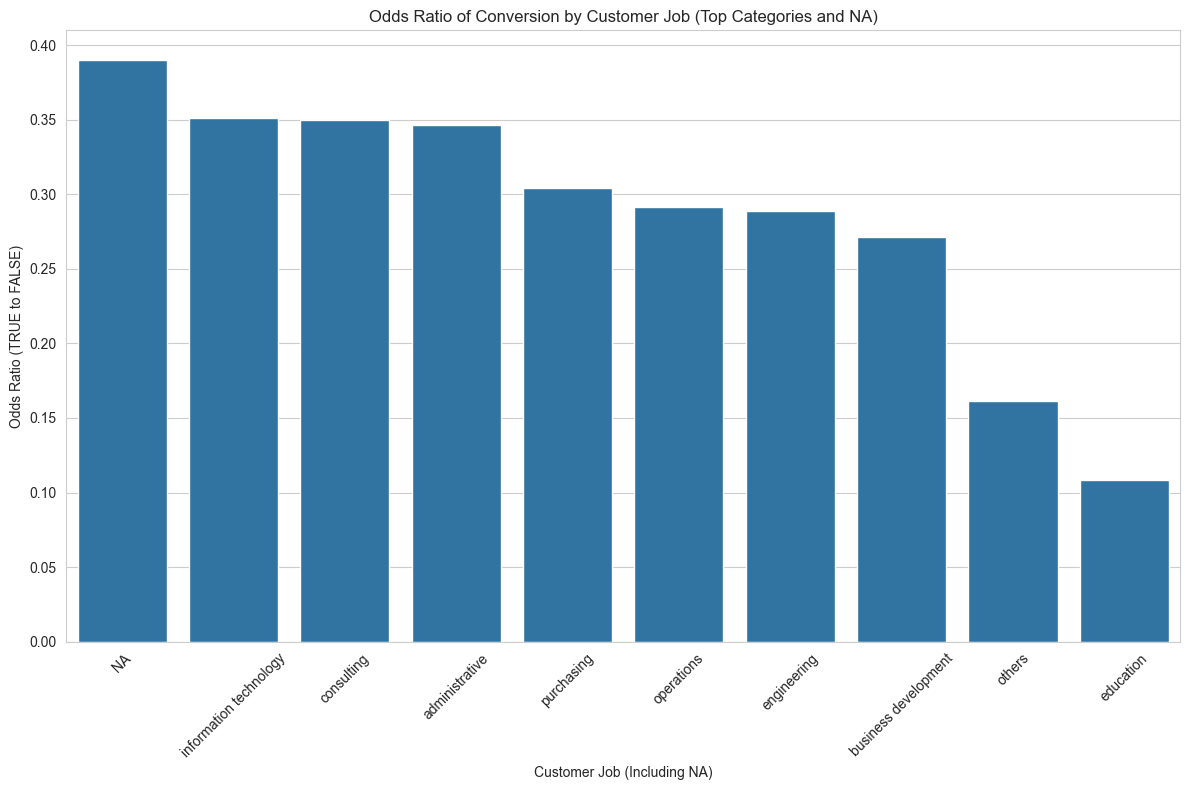

In [92]:
# Find the top 'customer_job' categories by count, excluding NAs
top_categories_counts = df['customer_job'].value_counts().nlargest(10)

# Include NA by creating a new category for visualization
df['customer_job'] = df['customer_job'].fillna('NA')

# Ensure the new "NA" category is included only if you want to compare it directly
df.loc[df['customer_job'].isna(), 'customer_job'] = 'NA'
top_categories_with_na = top_categories_counts.index.tolist() + ['NA']

df_filtered = df[df['customer_job'].isin(top_categories_with_na)]

# Calculate counts and odds ratios
conversion_counts = df_filtered.groupby('customer_job')['is_converted'].value_counts().unstack(fill_value=0)
conversion_counts['odds_ratio'] = conversion_counts['TRUE'] / conversion_counts.get('FALSE', 1)  # Avoid division by zero

# Reset index for plotting
conversion_counts.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=conversion_counts, x='customer_job', y='odds_ratio', order=conversion_counts.sort_values('odds_ratio', ascending=False)['customer_job'])
plt.xticks(rotation=45)
plt.xlabel('Customer Job (Including NA)')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Customer Job (Top Categories and NA)')
plt.tight_layout()
plt.show()


## product_category

In [93]:
df['product_category'] = df['product_category'].fillna('NA')

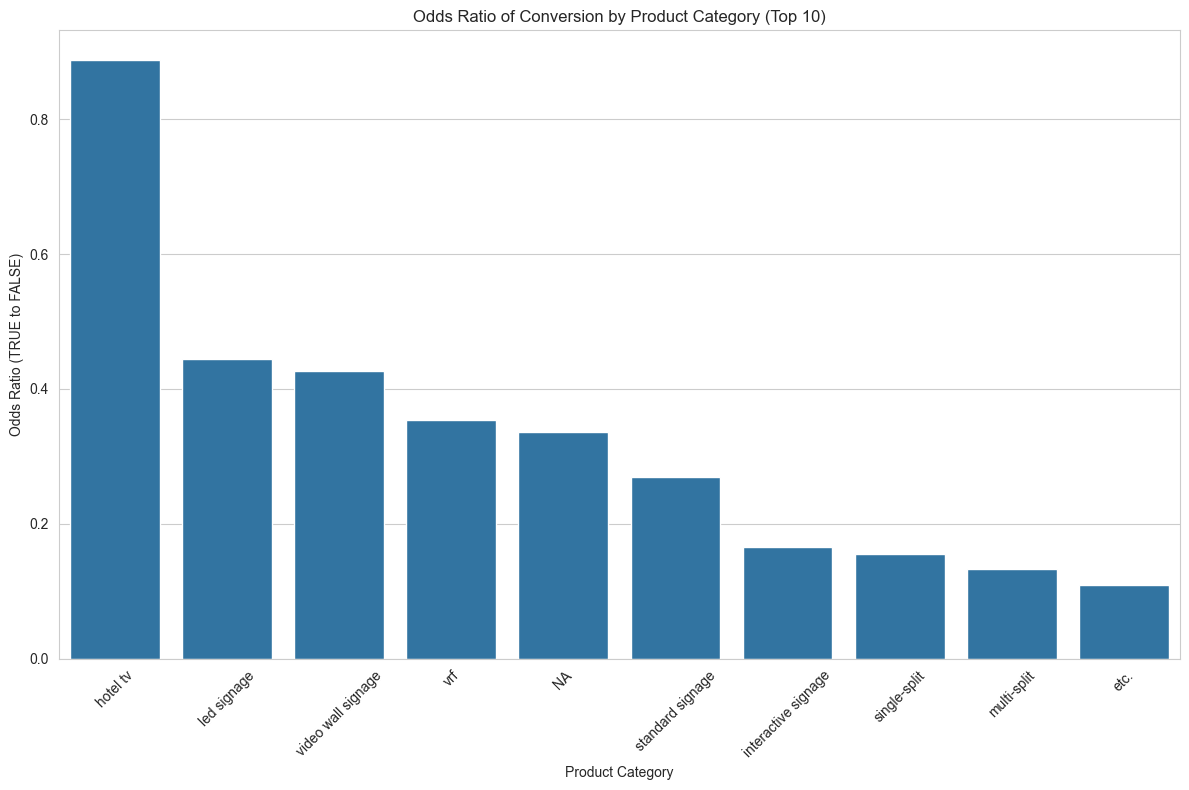

In [94]:
# Find the top 10 'product_category' categories by count
top_10_product_categories = df['product_category'].value_counts().nlargest(10).index

# Filter the DataFrame to keep only rows with the top 10 'product_category' values
df_top_10_product_categories = df[df['product_category'].isin(top_10_product_categories)]

# Calculate counts and odds ratios
conversion_counts_top_10 = df_top_10_product_categories.groupby('product_category')['is_converted'].value_counts().unstack(fill_value=0)
conversion_counts_top_10['odds_ratio'] = conversion_counts_top_10['TRUE'] / conversion_counts_top_10.get('FALSE', 1)  # Avoid division by zero

# Reset index for plotting
conversion_counts_top_10.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=conversion_counts_top_10, x='product_category', y='odds_ratio', order=conversion_counts_top_10.sort_values('odds_ratio', ascending=False)['product_category'])
plt.xticks(rotation=45)
plt.xlabel('Product Category')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Product Category (Top 10)')
plt.tight_layout()
plt.show()

In [95]:
# # Create a new column to differentiate between NA and non-NA 'product_category' values
# df['product_category'] = np.where(df['product_category'].isna(), 'NA', 'Filled')

# # Calculate counts and odds ratios for NA vs. Non-NA
# conversion_counts_status = df.groupby('product_category')['is_converted'].value_counts().unstack(fill_value=0)
# conversion_counts_status['odds_ratio'] = conversion_counts_status['TRUE'] / conversion_counts_status.get('FALSE', 1)

# # Reset index for plotting
# conversion_counts_status.reset_index(inplace=True)

# plt.figure(figsize=(8, 6))
# sns.barplot(data=conversion_counts_status, x='product_category', y='odds_ratio')
# plt.xlabel('Product Category Status (NA vs. Filled)')
# plt.ylabel('Odds Ratio (TRUE to FALSE)')
# plt.title('Odds Ratio of Conversion: NA vs. Filled Product Category')
# plt.tight_layout()
# plt.show()

# #no more NA


## NA 1000개 행 이하

In [96]:
for col in df.columns:
    if df[col].isnull().sum() > 1:
        print(col, df[col].isnull().sum()/len(df)*100)
        print(col, df[col].isnull().sum())

inquiry_type 24.51147789793208
inquiry_type 1292


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5271 non-null   int64  
 1   bant_submit              5271 non-null   float64
 2   customer_country         5271 non-null   object 
 3   business_unit            5271 non-null   object 
 4   com_reg_ver_win_rate     5271 non-null   float64
 5   customer_idx             5271 non-null   int64  
 6   customer_type            5271 non-null   object 
 7   enterprise               5271 non-null   object 
 8   historical_existing_cnt  5271 non-null   float64
 9   id_strategic_ver         5271 non-null   float64
 10  it_strategic_ver         5271 non-null   float64
 11  idit_strategic_ver       5271 non-null   float64
 12  customer_job             5271 non-null   object 
 13  lead_desc_length         5271 non-null   int64  
 14  inquiry_type            

In [98]:
df_dropped = df.dropna(subset=['customer_country','inquiry_type'])
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3979 entries, 1 to 5270
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       3979 non-null   int64  
 1   bant_submit              3979 non-null   float64
 2   customer_country         3979 non-null   object 
 3   business_unit            3979 non-null   object 
 4   com_reg_ver_win_rate     3979 non-null   float64
 5   customer_idx             3979 non-null   int64  
 6   customer_type            3979 non-null   object 
 7   enterprise               3979 non-null   object 
 8   historical_existing_cnt  3979 non-null   float64
 9   id_strategic_ver         3979 non-null   float64
 10  it_strategic_ver         3979 non-null   float64
 11  idit_strategic_ver       3979 non-null   float64
 12  customer_job             3979 non-null   object 
 13  lead_desc_length         3979 non-null   int64  
 14  inquiry_type             3979

## customer_country

In [99]:
print(len(df.columns))
df.drop(columns=['customer_country','inquiry_type'], inplace=True)

30


In [100]:
df.columns

Index(['id', 'bant_submit', 'business_unit', 'com_reg_ver_win_rate',
       'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'product_category', 'product_subcategory', 'product_modelname',
       'customer_country.1', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted'],
      dtype='object')

## customer_country.1

In [101]:
def extract_country(value):
    if pd.isna(value) or not isinstance(value, str):
        return 'NA'  # Return 'NA' for NaN values and non-string types
    
    if value.startswith('//'):
        country = value[2:]
        if not country or country.count('/') == 0:
            return 'NA'
        if country.count('//') > 0:
            country_parts = country.split('//')
            country = country_parts[-1]
        return country.strip().title()  # Trim spaces and standardize capitalization
    
    elif '/' in value:
        parts = value.strip('/').split('/')
        return parts[-1].strip().title()  # Trim spaces and standardize capitalization
    
    return value.strip().title()

# Assuming df is your DataFrame and it contains a column 'customer_country.1'
df['customer_country_normalized'] = df['customer_country.1'].apply(extract_country)

# Display the first few rows to verify the transformation
print(df[['customer_country.1', 'customer_country_normalized']].head())

                                  customer_country.1  \
0                                        /  / Brazil   
1  400 N State Of Franklin Rd  Cloud IT / Johnson...   
2                                         /  / U.A.E   
3                         / Madison  / United States   
4                               / Sao Paulo / Brazil   

  customer_country_normalized  
0                      Brazil  
1               United States  
2                       U.A.E  
3               United States  
4                      Brazil  


In [102]:
df['customer_country.1'] = df['customer_country_normalized']
df.drop(columns=['customer_country_normalized'], inplace=True)
len(df.columns)

28

In [103]:
# # Remove leading and trailing spaces from the 'customer_country_normalized' column
# df['customer_country_normalized'] = df['customer_country_normalized'].str.strip()

# # Display the first few rows to verify that the spaces have been removed
# print(df[['customer_country.1', 'customer_country_normalized']].head())

In [104]:
df['customer_country.1'].fillna('NA', inplace=True)

#count NA values in customer_country.1
df['customer_country.1'].isnull().sum()

0

In [105]:
len(df.columns)

28

## print pre-processed 

In [106]:
df.to_csv('preprocessed_submission.csv', index=False)